# DETR Knowledge Distillation on KITTI Dataset

This notebook demonstrates the complete pipeline for training a distilled DETR model on the KITTI dataset.

## Overview

1. **Setup**: Install dependencies and import libraries
2. **Configuration**: Load from YAML file
3. **Data Preparation**: Download and convert KITTI to COCO format
4. **Dataset Loading**: Create PyTorch datasets
5. **Model Setup**: Load teacher and student models
6. **Training**: Train with knowledge distillation
7. **Evaluation**: Evaluate with COCO metrics
8. **Visualization**: Visualize predictions

## 1. Setup and Installation

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install -q torch torchvision transformers pycocotools pillow tqdm pyyaml matplotlib opencv-python

In [3]:
import os
!git clone https://github.com/HenryNVP/object-detection.git
%cd object-detection
print(f"Working directory: {os.getcwd()}")

Cloning into 'object-detection'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 148 (delta 66), reused 112 (delta 36), pack-reused 0 (from 0)
Receiving objects: 100% (148/148), 6.24 MiB | 20.48 MiB/s, done.
Resolving deltas: 100% (66/66), done.
/content/object-detection
Working directory: /content/object-detection


## 2. Import Libraries

In [4]:
import sys
import json
import random
import yaml
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm.auto import tqdm
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from torch.utils.data import DataLoader

from src.datasets.kitti_coco import build_kitti_coco_dataset, collate_fn
from src.models import build_teacher_student_models
from src.distillation import DistillationLoss, DistillationTrainer
from src.utils import get_device, seed_all, EarlyStopping

print("✓ All imports successful")
device = get_device()
print(f"Device: {get_device()}")

✓ All imports successful
Device: cuda


## 3. Load Configuration from YAML

In [62]:
# Load configuration from YAML file
config_path = Path('configs/distillation.yaml')
with open(config_path) as f:
    config = yaml.safe_load(f)

CONFIG = {
    'kitti_root': './kitti_data/training',
    'data_root': './kitti_coco',
    'output_dir': './output/distillation_notebook',
    'num_labels': config['data']['num_labels'],
    'train_split': 0.8,
    'max_samples': 1000,
    'teacher_model': config['model']['teacher'],
    'student_model': config['model']['student'],
    'batch_size': config['data']['batch_size'],
    'num_workers': config['data']['num_workers'],
    'epochs': 10,
    'learning_rate': config['training']['learning_rate'],
    'weight_decay': config['training']['weight_decay'],
    'temperature': config['distillation']['temperature'],
    'alpha': config['distillation']['alpha'],
    'seed': 42,
    'device': None,
}

## 4. Data Preparation

Download KITTI dataset and convert to COCO format if needed.


In [6]:
# Copy processed dataset from drive
!cp -r /content/gdrive/MyDrive/object-detection/kitti_coco /content/object-detection

In [ ]:
# Download KITTI
!python scripts/download_kitti.py --output-dir ./kitti_data


KITTI Object Detection Dataset Downloader
--------------------------------------------------
Output directory: kitti_data
--------------------------------------------------

data_object_image_2.zip:   1% 152M/12.6G [00:07<10:15, 20.2MB/s]
Traceback (most recent call last):
  File "/usr/lib/python3.12/urllib/request.py", line 268, in urlretrieve
    while block := fp.read(bs):
                   ^^^^^^^^^^^
  File "/usr/lib/python3.12/http/client.py", line 479, in read
    s = self.fp.read(amt)
        ^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/socket.py", line 720, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/ssl.py", line 1251, in recv_into
    return self.read(nbytes, buffer)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/ssl.py", line 1103, in read
    return self._sslobj.read(len, buffer)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt

During handling of the above exception, another e

In [7]:
# Preprocess data
!python scripts/prepare_kitti_coco.py \
    --train-split 0.6 --val-split 0.2 --test-split 0.2 \
    --max-samples 1000

print("\n✓ Dataset ready!")

KITTI to COCO Converter
--------------------------------------------------
KITTI root: kitti_data/training
Output dir: kitti_coco
Train split: 0.6
Val split: 0.2
Test split: 0.2
Random seed: 42
--------------------------------------------------
Traceback (most recent call last):
  File "/content/object-detection/scripts/prepare_kitti_coco.py", line 360, in <module>
    main()
  File "/content/object-detection/scripts/prepare_kitti_coco.py", line 258, in main
    raise ValueError(f"KITTI root not found: {args.kitti_root}")
ValueError: KITTI root not found: kitti_data/training

✓ Dataset ready!


{
  "info": {
    "description": "KITTI train set in COCO format (KITTI class names)",
    "version": "1.0",
    "year": 2024
  },
  "licenses": [],
  "images": [
    {
      "id": 1,
      "file_name": "000776.png",
      "width": 1242,
      "height": 375
    },
    {
      "id": 2,
      "file_name": "000507.png",
      "width": 1242,
      "height": 375
    },
    {
      "id": 3,
      "file_name": "000895.png",
      "width": 1242,
      "height": 375
    },
    {
      "id": 4,
      "file_name": "000922.png",
      "width": 1242,
      "height": 375
    },
    {
      "id": 5,
      "file_name": "000033.png",
      "width": 1242,
      "height": 375
    },
    {
      "id": 6,
      "file_name": "000483.png",
      "width": 1242,
      "height": 375
    },
    {
      "id": 7,
      "file_name": "000085.png",
      "width": 1242,
      "height": 375
    },
    {
      "id": 8,
      "file_name": "000750.png",
      "width": 1242,
      "height": 375
    },
    {
      "id": 9,


In [32]:
from pycocotools.coco import COCO

coco = COCO(file_path)
print(len(coco.getImgIds()), "images")
print(len(coco.getAnnIds()), "annotations")
print(coco.loadCats(coco.getCatIds()))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
600 images
3088 annotations
[{'id': 1, 'name': 'Car'}, {'id': 2, 'name': 'Pedestrian'}, {'id': 3, 'name': 'Cyclist'}, {'id': 4, 'name': 'Truck'}, {'id': 5, 'name': 'Tram'}, {'id': 6, 'name': 'Misc'}]


## 5. Load Datasets and Create Data Loaders


In [8]:
print("Loading datasets...")
print("📊 Data Split Strategy:")
print("  • Train (60%): For training teacher & student")
print("  • Val (20%): For early stopping & monitoring during training")
print("  • Test (20%): For final evaluation ONLY (never seen during training)")
print()

# Define transforms to convert PIL images to tensors
import torchvision.transforms as T

def get_transform():
    """Basic transform to convert PIL images to tensors."""
    return T.Compose([
        T.ToTensor(),
    ])

# Load all three splits
train_dataset = build_kitti_coco_dataset(
    split='train',
    data_root=CONFIG['data_root'],
    transforms=None,  # We'll use image_processor in trainer
)

val_dataset = build_kitti_coco_dataset(
    split='val',
    data_root=CONFIG['data_root'],
    transforms=None,
)

test_dataset = build_kitti_coco_dataset(
    split='test',
    data_root=CONFIG['data_root'],
    transforms=None,
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    collate_fn=collate_fn,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    collate_fn=collate_fn,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    collate_fn=collate_fn,
)

print(f"✓ Train dataset: {len(train_dataset)} samples ({len(train_loader)} batches)")
print(f"✓ Val dataset: {len(val_dataset)} samples ({len(val_loader)} batches)")
print(f"✓ Test dataset: {len(test_dataset)} samples ({len(test_loader)} batches)")
print(f"\n💡 Train & val used during training, test for final evaluation only!")

Loading datasets...
📊 Data Split Strategy:
  • Train (60%): For training teacher & student
  • Val (20%): For early stopping & monitoring during training
  • Test (20%): For final evaluation ONLY (never seen during training)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
✓ Train dataset: 600 samples (25 batches)
✓ Val dataset: 200 samples (9 batches)
✓ Test dataset: 200 samples (9 batches)

💡 Train & val used during training, test for final evaluation only!


## 6. Load Teacher and Student Models
**Note**: Using `facebook/detr-resnet-50` (official Facebook DETR model) as teacher.  Creating a smaller student model for distillation by:- **Same backbone**: ResNet-50 (to avoid channel mismatch issues)- **Fewer transformer layers**: 3 vs 6 (both encoder and decoder)- **Fewer attention heads**: 4 vs 8- **Smaller FFN dimension**: 1024 vs 2048- **Result**: ~30-40% parameter reduction while maintaining compatibility

In [34]:
from transformers import DetrForObjectDetection, DetrImageProcessor, DetrConfig
import torch.nn as nn

print("Loading models...")

# Use facebook/detr-resnet-50 (available on HuggingFace)
teacher_model_name = "facebook/detr-resnet-50"
print(f"Teacher: {teacher_model_name} (ResNet-50 backbone)")

# Load teacher model and image processor
image_processor = DetrImageProcessor.from_pretrained(teacher_model_name)
teacher_model = DetrForObjectDetection.from_pretrained(
    teacher_model_name,
    num_labels=CONFIG['num_labels'],
    ignore_mismatched_sizes=True
)
teacher_model = teacher_model.to(device)

print("Teacher model loaded")
print(teacher_model)

Loading models...
Teacher: facebook/detr-resnet-50 (ResNet-50 backbone)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

Teacher model loaded
DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1

In [ ]:
# Freeze teacher backbone completely for first 10 epochs
# After epoch 10, we'll unfreeze the last layer (layer4) for progressive fine-tuning
print("Freezing teacher backbone completely (will unfreeze layer4 after epoch 10)...")

# Get the backbone model
backbone = teacher_model.model.backbone.conv_encoder.model

# Freeze all backbone layers initially
for param in backbone.parameters():
    param.requires_grad = False
print("✓ All backbone layers frozen (layer1, layer2, layer3, layer4)")

# Keep transformer and other parts trainable
for name, param in teacher_model.named_parameters():
    if "backbone" not in name:
        param.requires_grad = True

# Count trainable parameters
trainable_params = sum(p.numel() for p in teacher_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in teacher_model.parameters())
frozen_params = total_params - trainable_params

print(f"\n✓ Teacher backbone fully frozen")
print(f"  Trainable parameters: {trainable_params:,} / {total_params:,} ({trainable_params/total_params*100:.1f}%)")
print(f"  Frozen parameters: {frozen_params:,} ({frozen_params/total_params*100:.1f}%)")
print(f"  Note: layer4 will be unfrozen after epoch 10")


In [63]:
from transformers import DetrConfig, DetrForObjectDetection, ResNetConfig

student_cfg = DetrConfig.from_pretrained("facebook/detr-resnet-50")
student_cfg.num_labels = CONFIG['num_labels']

# plug in a ResNet-34 backbone
# out_indices selects the feature stages the DETR wrapper will read;
# 0..3 is typical for ResNet backbones in HF DETR.
backbone_cfg = ResNetConfig.from_pretrained("microsoft/resnet-34", out_indices=[0, 1, 2, 3])
student_cfg.backbone_config = backbone_cfg
# (optional) if you prefer a Hub id instead of a config:
# student_cfg.backbone = "microsoft/resnet-34"
# student_cfg.use_pretrained_backbone = True

# shrink the transformer for compression
student_cfg.d_model = 256
student_cfg.encoder_attention_heads = 8
student_cfg.decoder_attention_heads = 8
student_cfg.encoder_ffn_dim = 2048
student_cfg.decoder_ffn_dim = 2048

student_model = DetrForObjectDetection(student_cfg).to(device)

In [64]:
print(student_model)

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [66]:
# Freeze the student backbone
for param in student_model.model.backbone.parameters():
    param.requires_grad = False

# Print trainable parameters
trainable_params = sum(p.numel() for p in student_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in student_model.parameters())
print(f"✓ Student backbone frozen")
print(f"Trainable parameters: {trainable_params:,} / {total_params:,}")

✓ Student backbone frozen
Trainable parameters: 18,048,011 / 41,502,923


---

## 7. Fine-tune Teacher Model on KITTI

### 📋 Why Fine-tuning is Necessary:

The teacher model (`facebook/detr-resnet-50`) was loaded with `num_labels=6` for KITTI, but it was pretrained on COCO (80 classes). Therefore, it is neccessary to fine-tune the teacher on KITTI first.

**Training Plan:**
- Fine-tune for 10 epochs
- Use supervised learning
- Save best checkpoint

---

### 7.1. Setup Fine-tuning


In [13]:
@torch.no_grad()
def evaluate_model(model, data_loader, device, threshold=0.3):
    """Evaluate model on validation set and return predictions in COCO format."""
    model.eval()
    predictions = []

    for images, targets in tqdm(data_loader, desc="Evaluating"):
        # Process images with image_processor
        inputs = image_processor(images=images, return_tensors="pt")
        pixel_values = inputs["pixel_values"].to(device)

        outputs = model(pixel_values=pixel_values)

        for i, target in enumerate(targets):
            image_id = target['image_id'].item()
            logits = outputs.logits[i]
            boxes = outputs.pred_boxes[i]

            # Get predicted class and score
            scores = logits.softmax(-1)[:, :-1].max(-1)
            labels = scores.indices
            scores = scores.values

            # Filter low confidence predictions
            keep = scores > threshold

            # Get original image size
            if hasattr(images[i], 'size'):
                img_w, img_h = images[i].size
            else:
                img_h, img_w = images[i].shape[-2:]

            for box, score, label in zip(boxes[keep], scores[keep], labels[keep]):
                # Convert from normalized [cx, cy, w, h] to COCO [x, y, w, h]
                cx, cy, w, h = box.cpu().tolist()
                x = (cx - w/2) * img_w
                y = (cy - h/2) * img_h
                w_box = w * img_w
                h_box = h * img_h

                predictions.append({
                    'image_id': image_id,
                    'category_id': int(label.item()) + 1,
                    'bbox': [x, y, w_box, h_box],
                    'score': float(score.item()),
                })

    return predictions

print("✓ Evaluation function defined")


✓ Evaluation function defined


In [51]:
# Put model in training mode
teacher_model.train()

# Freeze backbone
for name, param in teacher_model.named_parameters():
    if "backbone" in name:
        param.requires_grad = False
    else:
        param.requires_grad = True

trainable_params = [p for p in teacher_model.parameters() if p.requires_grad]

teacher_optimizer = torch.optim.AdamW(
    trainable_params,
    lr=1e-4,
    weight_decay=1e-4
)

In [52]:
# Print trainable parameters
teacher_trainable_params = sum(p.numel() for p in teacher_model.parameters() if p.requires_grad)
teacher_total_params = sum(p.numel() for p in teacher_model.parameters())
print(f"✓ Teacher backbone frozen")
print(f"Trainable parameters: {teacher_trainable_params:,} / {teacher_total_params:,}")

✓ Teacher backbone frozen
Trainable parameters: 18,048,011 / 41,502,923


In [37]:
!rm -rf output/

In [38]:
def train_teacher_epoch(model, dataloader, optimizer, device, epoch):
    """Train teacher model for one epoch."""
    model.train()
    total_loss = 0
    num_batches = 0

    pbar = tqdm(dataloader, desc=f"Fine-tuning Epoch {epoch}")
    for images, targets in pbar:
        # Process images and targets
        inputs = image_processor(images=images, return_tensors="pt")
        pixel_values = inputs["pixel_values"].to(device)

        # Prepare targets for DETR
        labels = []
        for i, target in enumerate(targets):
            # Get image size from processed input
            img_h, img_w = images[i].size[1], images[i].size[0] if hasattr(images[i], 'size') else (images[i].shape[-2], images[i].shape[-1])

            # Convert boxes from [x1, y1, x2, y2] to normalized [cx, cy, w, h]
            boxes = target["boxes"]  # [N, 4] in [x1, y1, x2, y2] format

            # Convert to [cx, cy, w, h]
            x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
            cx = (x1 + x2) / 2
            cy = (y1 + y2) / 2
            w = x2 - x1
            h = y2 - y1

            # Normalize by image size
            cx = cx / img_w
            cy = cy / img_h
            w = w / img_w
            h = h / img_h

            boxes_cxcywh = torch.stack([cx, cy, w, h], dim=1)

            # Convert labels from 1-indexed to 0-indexed
            class_labels = target["labels"] - 1

            # Convert target to DETR format
            label = {
                "class_labels": class_labels.to(device),
                "boxes": boxes_cxcywh.to(device),
            }
            labels.append(label)

        # Forward pass
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track metrics
        total_loss += loss.item()
        num_batches += 1

        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_loss = total_loss / num_batches
    return avg_loss


@torch.no_grad()
def validate_teacher(model, dataloader, device):
    """Validate teacher model."""
    model.eval()
    total_loss = 0
    num_batches = 0

    for images, targets in tqdm(dataloader, desc="Validating"):
        # Process images and targets
        inputs = image_processor(images=images, return_tensors="pt")
        pixel_values = inputs["pixel_values"].to(device)

        # Prepare targets
        labels = []
        for i, target in enumerate(targets):
            # Get image size
            img_h, img_w = images[i].size[1], images[i].size[0] if hasattr(images[i], 'size') else (images[i].shape[-2], images[i].shape[-1])

            # Convert boxes from [x1, y1, x2, y2] to normalized [cx, cy, w, h]
            boxes = target["boxes"]
            x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
            cx = (x1 + x2) / 2
            cy = (y1 + y2) / 2
            w = x2 - x1
            h = y2 - y1
            cx = cx / img_w
            cy = cy / img_h
            w = w / img_w
            h = h / img_h
            boxes_cxcywh = torch.stack([cx, cy, w, h], dim=1)

            # Convert labels from 1-indexed to 0-indexed
            class_labels = target["labels"] - 1

            label = {
                "class_labels": class_labels.to(device),
                "boxes": boxes_cxcywh.to(device),
            }
            labels.append(label)

        # Forward pass
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        total_loss += loss.item()
        num_batches += 1

    avg_loss = total_loss / num_batches
    return avg_loss

print("✓ Training functions defined")


✓ Training functions defined


In [ ]:
# Progressive unfreezing: Unfreeze layer4 after epoch 10
# This will be called during training loop
def unfreeze_layer4_if_needed(model, optimizer, epoch):
    """Unfreeze backbone layer4 after epoch 10 for progressive fine-tuning."""
    if epoch > 10:
        backbone = model.model.backbone.conv_encoder.model
        if hasattr(backbone, 'layer4'):
            # Check if already unfrozen
            if not any(p.requires_grad for p in backbone.layer4.parameters()):
                print("🔄 Unfreezing backbone layer4 for progressive fine-tuning...")
                for param in backbone.layer4.parameters():
                    param.requires_grad = True
                print("✓ layer4 unfrozen (now trainable)")
                
                # Update optimizer to include newly unfrozen parameters
                trainable_params = [p for p in model.parameters() if p.requires_grad]
                new_optimizer = torch.optim.AdamW(
                    trainable_params,
                    lr=1e-4,
                    weight_decay=1e-4
                )
                # Copy optimizer state if possible
                try:
                    new_optimizer.load_state_dict(optimizer.state_dict())
                except:
                    pass  # Start fresh optimizer state
                
                # Count trainable parameters
                trainable_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
                total_count = sum(p.numel() for p in model.parameters())
                print(f"  Trainable parameters: {trainable_count:,} / {total_count:,} ({trainable_count/total_count*100:.1f}%)")
                return new_optimizer
    return optimizer

print("✓ Progressive unfreezing function defined")


---

### 7.2. Run Fine-tuning Training Loop

**⚠️ Data Format Note:**
The training functions correctly handle:
- ✅ Label conversion: 1-indexed (COCO) → 0-indexed (DETR)
- ✅ Box conversion: [x1,y1,x2,y2] → normalized [cx,cy,w,h]

In [ ]:
# Fine-tune teacher model WITH EARLY STOPPING
TEACHER_EPOCHS = 20  # Max epochs (backbone frozen for first 10, then layer4 unfrozen)
teacher_checkpoint_dir = Path(CONFIG['output_dir']) / 'teacher_finetuned'
teacher_checkpoint_dir.mkdir(parents=True, exist_ok=True)

print(f"🚀 Starting Teacher Fine-tuning (max {TEACHER_EPOCHS} epochs)")
print(f"   Early stopping: patience=4 epochs")
print(f"   Backbone frozen for first 10 epochs, then layer4 unfrozen")
print("=" * 70)

# Initialize early stopping
early_stopping = EarlyStopping(patience=4, mode='min', verbose=True)

best_val_loss = float('inf')
history = {'train_loss': [], 'val_loss': []}

for epoch in range(1, TEACHER_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{TEACHER_EPOCHS}")
    print("-" * 50)
    
    # Unfreeze layer4 after epoch 10 for progressive fine-tuning
    teacher_optimizer = unfreeze_layer4_if_needed(teacher_model, teacher_optimizer, epoch)

    # Train
    train_loss = train_teacher_epoch(
        teacher_model, train_loader, teacher_optimizer, device, epoch
    )
    history['train_loss'].append(train_loss)
    print(f"Train Loss: {train_loss:.4f}")

    # Validate
    val_loss = validate_teacher(teacher_model, val_loader, device)
    history['val_loss'].append(val_loss)
    print(f"Val Loss: {val_loss:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_checkpoint_path = teacher_checkpoint_dir / 'best.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': teacher_model.state_dict(),
            'optimizer_state_dict': teacher_optimizer.state_dict(),
            'val_loss': val_loss,
        }, best_checkpoint_path)
        print(f"✓ Saved best checkpoint: {best_checkpoint_path}")

    # Save epoch checkpoint
    epoch_checkpoint_path = teacher_checkpoint_dir / f'epoch_{epoch}.pth'
    torch.save({
        'epoch': epoch,
        'model_state_dict': teacher_model.state_dict(),
        'optimizer_state_dict': teacher_optimizer.state_dict(),
        'val_loss': val_loss,
    }, epoch_checkpoint_path)

    # Check early stopping
    if early_stopping(val_loss, epoch):
        print(f"\n⏹️  Training stopped early at epoch {epoch}/{TEACHER_EPOCHS}")
        break

print("\n" + "=" * 70)
print(f"✅ Teacher fine-tuning complete!")
print(f"Training stopped at epoch: {epoch}/{TEACHER_EPOCHS}")
print(f"Best val loss: {best_val_loss:.4f} (epoch {early_stopping.best_epoch})")
print(f"Checkpoints saved to: {teacher_checkpoint_dir}")

# Load best model
print("\nLoading best checkpoint...")
checkpoint = torch.load(teacher_checkpoint_dir / 'best.pth')
teacher_model.load_state_dict(checkpoint['model_state_dict'])
teacher_model.eval()
for param in teacher_model.parameters():
    param.requires_grad = False
print("✓ Best model loaded and frozen for distillation")

🚀 Starting Teacher Fine-tuning (max 10 epochs)
   Early stopping: patience=2 epochs

Epoch 1/10
--------------------------------------------------


Fine-tuning Epoch 1:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 2.1462


Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 1.7076
✓ Saved best checkpoint: output/distillation_notebook/teacher_finetuned/best.pth

Epoch 2/10
--------------------------------------------------


Fine-tuning Epoch 2:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.6104


Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 1.5131
✓ Saved best checkpoint: output/distillation_notebook/teacher_finetuned/best.pth
  ✓ Validation improved (patience reset: 0/2)

Epoch 3/10
--------------------------------------------------


Fine-tuning Epoch 3:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.4670


Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 1.4070
✓ Saved best checkpoint: output/distillation_notebook/teacher_finetuned/best.pth
  ✓ Validation improved (patience reset: 0/2)

Epoch 4/10
--------------------------------------------------


Fine-tuning Epoch 4:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.3595


Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 1.3050
✓ Saved best checkpoint: output/distillation_notebook/teacher_finetuned/best.pth
  ✓ Validation improved (patience reset: 0/2)

Epoch 5/10
--------------------------------------------------


Fine-tuning Epoch 5:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.2929


Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 1.2108
✓ Saved best checkpoint: output/distillation_notebook/teacher_finetuned/best.pth
  ✓ Validation improved (patience reset: 0/2)

Epoch 6/10
--------------------------------------------------


Fine-tuning Epoch 6:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.2398


Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 1.1968
✓ Saved best checkpoint: output/distillation_notebook/teacher_finetuned/best.pth
  ✓ Validation improved (patience reset: 0/2)

Epoch 7/10
--------------------------------------------------


Fine-tuning Epoch 7:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.2134


Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 1.1839
✓ Saved best checkpoint: output/distillation_notebook/teacher_finetuned/best.pth
  ✓ Validation improved (patience reset: 0/2)

Epoch 8/10
--------------------------------------------------


Fine-tuning Epoch 8:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.1843


Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 1.1839
  ⚠️  No improvement for 1 epoch(s) (patience: 1/2)

Epoch 9/10
--------------------------------------------------


Fine-tuning Epoch 9:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.1530


Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 1.0795
✓ Saved best checkpoint: output/distillation_notebook/teacher_finetuned/best.pth
  ✓ Validation improved (patience reset: 0/2)

Epoch 10/10
--------------------------------------------------


Fine-tuning Epoch 10:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 1.1124


Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Val Loss: 1.0885
  ⚠️  No improvement for 1 epoch(s) (patience: 1/2)

✅ Teacher fine-tuning complete!
Training stopped at epoch: 10/10
Best val loss: 1.0795 (epoch 9)
Checkpoints saved to: output/distillation_notebook/teacher_finetuned

Loading best checkpoint...
✓ Best model loaded and frozen for distillation


In [ ]:
---

## 7.4. Continue Training Teacher with Layer4 Unfrozen

Continue training the teacher model with the last backbone layer (layer4) unfrozen for additional fine-tuning.


In [ ]:
# Continue training teacher model with layer4 unfrozen
# Load the best checkpoint first (if not already loaded)
print("Loading best teacher checkpoint for continued training...")
best_checkpoint_path = teacher_checkpoint_dir / 'best.pth'
if best_checkpoint_path.exists():
    checkpoint = torch.load(best_checkpoint_path)
    teacher_model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✓ Loaded checkpoint from epoch {checkpoint['epoch']} (val_loss: {checkpoint['val_loss']:.4f})")
else:
    print("⚠️ No checkpoint found, using current model state")

# Unfreeze layer4 for continued training
print("\n🔄 Unfreezing backbone layer4 for continued fine-tuning...")
backbone = teacher_model.model.backbone.conv_encoder.model
if hasattr(backbone, 'layer4'):
    for param in backbone.layer4.parameters():
        param.requires_grad = True
    print("✓ layer4 unfrozen (now trainable)")

# Keep transformer and other parts trainable
for name, param in teacher_model.named_parameters():
    if "backbone" not in name:
        param.requires_grad = True

# Count trainable parameters
trainable_params = sum(p.numel() for p in teacher_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in teacher_model.parameters())
print(f"\n✓ Teacher model ready for continued training")
print(f"  Trainable parameters: {trainable_params:,} / {total_params:,} ({trainable_params/total_params*100:.1f}%)")

# Setup optimizer with all trainable parameters
trainable_params_list = [p for p in teacher_model.parameters() if p.requires_grad]
teacher_optimizer = torch.optim.AdamW(
    trainable_params_list,
    lr=1e-4,  # Can use lower LR for fine-tuning
    weight_decay=1e-4
)
print(f"✓ Optimizer setup complete (LR: 1e-4)")

# Set model to training mode
teacher_model.train()
print("✓ Model set to training mode")


In [ ]:
# Continue training teacher model with layer4 unfrozen
CONTINUE_EPOCHS = 10  # Number of additional epochs to train
print(f"🚀 Continuing Teacher Training with Layer4 Unfrozen")
print(f"   Additional epochs: {CONTINUE_EPOCHS}")
print(f"   Early stopping: patience=2 epochs")
print("=" * 70)

# Initialize early stopping for continued training
early_stopping_continue = EarlyStopping(patience=2, mode='min', verbose=True)

# Get the last epoch from checkpoint if available
start_epoch = 1
if best_checkpoint_path.exists():
    checkpoint = torch.load(best_checkpoint_path)
    start_epoch = checkpoint.get('epoch', 1) + 1
    print(f"Starting from epoch {start_epoch} (continuing from previous training)")

best_val_loss_continue = float('inf')
history_continue = {'train_loss': [], 'val_loss': []}

for epoch in range(start_epoch, start_epoch + CONTINUE_EPOCHS):
    print(f"\nEpoch {epoch}/{start_epoch + CONTINUE_EPOCHS - 1}")
    print("-" * 50)

    # Train
    train_loss = train_teacher_epoch(
        teacher_model, train_loader, teacher_optimizer, device, epoch
    )
    history_continue['train_loss'].append(train_loss)
    print(f"Train Loss: {train_loss:.4f}")

    # Validate
    val_loss = validate_teacher(teacher_model, val_loader, device)
    history_continue['val_loss'].append(val_loss)
    print(f"Val Loss: {val_loss:.4f}")

    # Save best model
    if val_loss < best_val_loss_continue:
        best_val_loss_continue = val_loss
        best_checkpoint_path_continue = teacher_checkpoint_dir / 'best_continue.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': teacher_model.state_dict(),
            'optimizer_state_dict': teacher_optimizer.state_dict(),
            'val_loss': val_loss,
        }, best_checkpoint_path_continue)
        print(f"✓ Saved best checkpoint: {best_checkpoint_path_continue}")

    # Save epoch checkpoint
    epoch_checkpoint_path = teacher_checkpoint_dir / f'continue_epoch_{epoch}.pth'
    torch.save({
        'epoch': epoch,
        'model_state_dict': teacher_model.state_dict(),
        'optimizer_state_dict': teacher_optimizer.state_dict(),
        'val_loss': val_loss,
    }, epoch_checkpoint_path)

    # Check early stopping
    if early_stopping_continue(val_loss, epoch):
        print(f"\n⏹️  Training stopped early at epoch {epoch}")
        break

print("\n" + "=" * 70)
print(f"✅ Continued teacher training complete!")
print(f"Training stopped at epoch: {epoch}")
print(f"Best val loss: {best_val_loss_continue:.4f} (epoch {early_stopping_continue.best_epoch})")
print(f"Checkpoints saved to: {teacher_checkpoint_dir}")

# Load best model from continued training
print("\nLoading best checkpoint from continued training...")
checkpoint_continue = torch.load(teacher_checkpoint_dir / 'best_continue.pth')
teacher_model.load_state_dict(checkpoint_continue['model_state_dict'])
teacher_model.eval()
print(f"✓ Best continued model loaded from epoch {checkpoint_continue['epoch']}")
print(f"  Validation loss: {checkpoint_continue['val_loss']:.4f}")


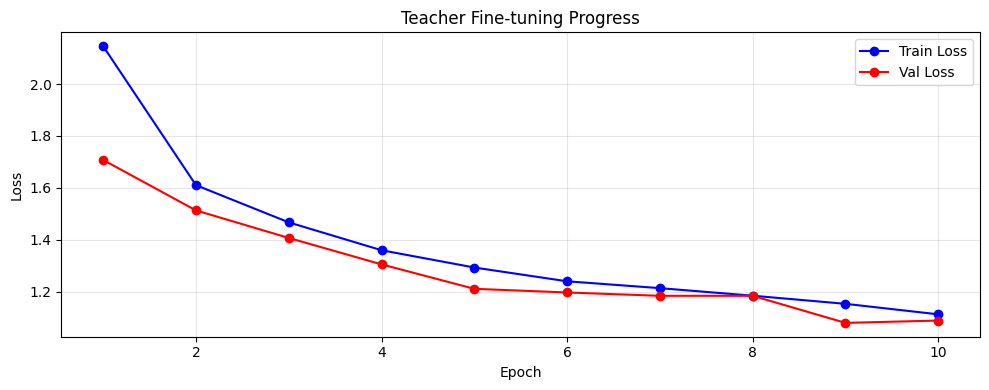


📊 Training Summary:
  Initial train loss: 2.1462
  Final train loss: 1.1124
  Initial val loss: 1.7076
  Final val loss: 1.0885


In [41]:
# Plot training history
plt.figure(figsize=(10, 4))

plt.subplot(1, 1, 1)
plt.plot(range(1, TEACHER_EPOCHS + 1), history['train_loss'], 'b-o', label='Train Loss')
plt.plot(range(1, TEACHER_EPOCHS + 1), history['val_loss'], 'r-o', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Teacher Fine-tuning Progress')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Training Summary:")
print(f"  Initial train loss: {history['train_loss'][0]:.4f}")
print(f"  Final train loss: {history['train_loss'][-1]:.4f}")
print(f"  Initial val loss: {history['val_loss'][0]:.4f}")
print(f"  Final val loss: {history['val_loss'][-1]:.4f}")

---

### 7.3. Evaluate Fine-tuned Teacher

In [53]:
# Load best teacher checkpoint
print("Loading best teacher checkpoint...")
best_checkpoint_path = teacher_checkpoint_dir / 'best.pth'
checkpoint = torch.load(best_checkpoint_path)
teacher_model.load_state_dict(checkpoint['model_state_dict'])

# Freeze teacher again for distillation
for param in teacher_model.parameters():
    param.requires_grad = False

teacher_model.eval()

print(f"✓ Loaded best teacher checkpoint from epoch {checkpoint['epoch']}")
print(f"✓ Teacher model frozen and ready for distillation")
print(f"  Validation loss: {checkpoint['val_loss']:.4f}")


Loading best teacher checkpoint...
✓ Loaded best teacher checkpoint from epoch 9
✓ Teacher model frozen and ready for distillation
  Validation loss: 1.0795


In [42]:
print("🔍 Evaluating FINE-TUNED teacher on test set...")
print("=" * 70)

teacher_predictions = evaluate_model(teacher_model, test_loader, device, threshold=0.3)
print(f"Predictions with threshold=0.3: {len(teacher_predictions)}")


🔍 Evaluating FINE-TUNED teacher on test set...


Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

Predictions with threshold=0.3: 2451


In [43]:
# Run KITTI evaluation on teacher
if len(teacher_predictions) > 0:
    print("\n📊 Teacher Model Performance:")
    print("=" * 70)
    ann_file = Path(CONFIG['data_root']) / 'annotations' / 'instances_test.json'

    coco_gt = COCO(str(ann_file))
    coco_dt = coco_gt.loadRes(teacher_predictions)
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    teacher_AP = coco_eval.stats[0]
    print(f"\n🎓 Teacher AP@0.5:0.95 = {teacher_AP:.4f}")


else:
    print("\n⚠️ No predictions to evaluate")
    print("Try lowering the threshold or training longer")
    teacher_AP = 0.0



📊 Teacher Model Performance:
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.38s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.114
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.218
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.098
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.112
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.156
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.052
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.145
 Average Recall     (AR) @[ IoU=0.5

---

## 8. Train Student Model with Knowledge Distillation


-  Teacher: Large, fine-tuned model (good performance)
-  Student: Smaller model (fewer parameters, faster inference)
-  Goal: Student learns from teacher's knowledge + ground truth

1. Teacher predictions → Soft targets (probability distributions)
2. Student learns from both:
   - Teacher's soft predictions (knowledge transfer)
   - Ground truth labels (supervised learning)
3. Combined loss = α × student_loss + (1-α) × distillation_loss

---

### Step 1: Setup Distillation Training


In [67]:
# Setup optimizer for student
optimizer = torch.optim.AdamW(
    student_model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay'],
)

# Setup distillation loss
distillation_loss = DistillationLoss(
    temperature=CONFIG['temperature'],
    alpha=CONFIG['alpha'],
)

# Create trainer with image_processor for PIL image handling
trainer = DistillationTrainer(
    teacher_model=teacher_model,
    student_model=student_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    distillation_loss=distillation_loss,
    device=device,
    output_dir=CONFIG['output_dir'],
    image_processor=image_processor,  # Pass processor to handle PIL images
)

print("✓ Distillation training setup complete")
print(f"  Learning rate: {CONFIG['learning_rate']}")
print(f"  Temperature: {CONFIG['temperature']}")
print(f"  Alpha (student weight): {CONFIG['alpha']}")
print(f"  Epochs: {CONFIG['epochs']}")


✓ Distillation training setup complete
  Learning rate: 0.0001
  Temperature: 2.0
  Alpha (student weight): 0.7
  Epochs: 10


---

### Step 2: Run Distillation Training

**Parameters:**
- Temperature: {CONFIG['temperature']} (softens probability distributions)
- Alpha: {CONFIG['alpha']} (balances student vs distillation loss)


In [68]:
!rm -f output/distillation_notebook/epoch_*.pth output/distillation_notebook/best.pth
print("✓ Deleted epoch_*.pth and best.pth from output/distillation_notebook")

✓ Deleted epoch_*.pth and best.pth from output/distillation_notebook


In [69]:
print(f"🚀 Starting Student Training with Knowledge Distillation")
print(f"   Max epochs: {CONFIG['epochs']}")
print(f"   Early stopping: patience=2 epochs")
print("=" * 70)

# Initialize early stopping for student
early_stopping_student = EarlyStopping(patience=2, mode='min', verbose=True)

best_val_loss = float('inf')
MAX_EPOCHS = CONFIG['epochs']

for epoch in range(1, MAX_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{MAX_EPOCHS}")
    print("-" * 50)

    # Train one epoch
    train_metrics = trainer.train_epoch(epoch)
    print(f"Train Loss: {train_metrics['train_loss']:.4f}")
    print(f"  - Student Loss: {train_metrics['train_student_loss']:.4f}")
    print(f"  - Distillation Loss: {train_metrics['train_distill_loss']:.4f}")

    # Validate
    val_metrics = trainer.validate()
    val_loss = val_metrics['val_loss']
    print(f"Val Loss: {val_loss:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trainer.save_checkpoint(epoch, val_loss, "best")

    # Save epoch checkpoint
    trainer.save_checkpoint(epoch, val_loss, f"epoch_{epoch}")

    # Check early stopping
    if early_stopping_student(val_loss, epoch):
        print(f"\n⏹️  Training stopped early at epoch {epoch}/{MAX_EPOCHS}")
        break

print("\n" + "=" * 70)
print(f"✅ Student training complete!")
print(f"Training stopped at epoch: {epoch}/{MAX_EPOCHS}")
print(f"Best val loss: {best_val_loss:.4f} (epoch {early_stopping_student.best_epoch})")
print(f"Checkpoints saved to: {CONFIG['output_dir']}")

🚀 Starting Student Training with Knowledge Distillation
   Max epochs: 10
   Early stopping: patience=2 epochs

Epoch 1/10
--------------------------------------------------


Epoch 1: 100%|██████████| 25/25 [01:01<00:00,  2.45s/it, loss=15.3100, student=7.5737, distill=33.3613]


Train Loss: 18.9947
  - Student Loss: 8.0091
  - Distillation Loss: 44.6278


Validation: 100%|██████████| 9/9 [00:14<00:00,  1.57s/it, val_loss=7.7582]


Val Loss: 7.6261
Saved checkpoint: output/distillation_notebook/best.pth
Saved checkpoint: output/distillation_notebook/epoch_1.pth

Epoch 2/10
--------------------------------------------------


Epoch 2: 100%|██████████| 25/25 [01:01<00:00,  2.46s/it, loss=14.7812, student=6.2786, distill=34.6206]


Train Loss: 14.6565
  - Student Loss: 6.7525
  - Distillation Loss: 33.0993


Validation: 100%|██████████| 9/9 [00:14<00:00,  1.57s/it, val_loss=6.5515]


Val Loss: 6.0685
Saved checkpoint: output/distillation_notebook/best.pth
Saved checkpoint: output/distillation_notebook/epoch_2.pth
  ✓ Validation improved (patience reset: 0/2)

Epoch 3/10
--------------------------------------------------


Epoch 3: 100%|██████████| 25/25 [01:01<00:00,  2.45s/it, loss=13.5752, student=5.6265, distill=32.1222]


Train Loss: 14.0594
  - Student Loss: 5.9066
  - Distillation Loss: 33.0826


Validation: 100%|██████████| 9/9 [00:13<00:00,  1.55s/it, val_loss=6.6406]


Val Loss: 6.0006
Saved checkpoint: output/distillation_notebook/best.pth
Saved checkpoint: output/distillation_notebook/epoch_3.pth
  ✓ Validation improved (patience reset: 0/2)

Epoch 4/10
--------------------------------------------------


Epoch 4: 100%|██████████| 25/25 [01:01<00:00,  2.45s/it, loss=13.9009, student=5.9656, distill=32.4164]


Train Loss: 14.0384
  - Student Loss: 5.8619
  - Distillation Loss: 33.1170


Validation:   0%|          | 0/9 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78db0ff454e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78db0ff454e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-

Val Loss: 6.0498
Saved checkpoint: output/distillation_notebook/epoch_4.pth
  ⚠️  No improvement for 1 epoch(s) (patience: 1/2)

Epoch 5/10
--------------------------------------------------


Epoch 5: 100%|██████████| 25/25 [01:01<00:00,  2.45s/it, loss=15.1558, student=6.1535, distill=36.1611]


Train Loss: 13.9976
  - Student Loss: 5.8537
  - Distillation Loss: 33.0001


Validation: 100%|██████████| 9/9 [00:14<00:00,  1.56s/it, val_loss=6.6233]


Val Loss: 5.9970
Saved checkpoint: output/distillation_notebook/best.pth
Saved checkpoint: output/distillation_notebook/epoch_5.pth
  ✓ Validation improved (patience reset: 0/2)

Epoch 6/10
--------------------------------------------------


Epoch 6: 100%|██████████| 25/25 [01:01<00:00,  2.45s/it, loss=14.3071, student=5.7890, distill=34.1826]


Train Loss: 14.0079
  - Student Loss: 5.8475
  - Distillation Loss: 33.0488


Validation: 100%|██████████| 9/9 [00:13<00:00,  1.55s/it, val_loss=6.6157]


Val Loss: 6.0087
Saved checkpoint: output/distillation_notebook/epoch_6.pth
  ⚠️  No improvement for 1 epoch(s) (patience: 1/2)

Epoch 7/10
--------------------------------------------------


Epoch 7: 100%|██████████| 25/25 [01:01<00:00,  2.45s/it, loss=13.7478, student=5.7083, distill=32.5067]


Train Loss: 13.9634
  - Student Loss: 5.8322
  - Distillation Loss: 32.9361


Validation: 100%|██████████| 9/9 [00:14<00:00,  1.56s/it, val_loss=6.5474]


Val Loss: 5.9434
Saved checkpoint: output/distillation_notebook/best.pth
Saved checkpoint: output/distillation_notebook/epoch_7.pth
  ✓ Validation improved (patience reset: 0/2)

Epoch 8/10
--------------------------------------------------


Epoch 8: 100%|██████████| 25/25 [01:01<00:00,  2.45s/it, loss=14.1708, student=6.0373, distill=33.1489]


Train Loss: 13.9583
  - Student Loss: 5.8039
  - Distillation Loss: 32.9852


Validation: 100%|██████████| 9/9 [00:14<00:00,  1.56s/it, val_loss=6.5814]


Val Loss: 5.9848
Saved checkpoint: output/distillation_notebook/epoch_8.pth
  ⚠️  No improvement for 1 epoch(s) (patience: 1/2)

Epoch 9/10
--------------------------------------------------


Epoch 9: 100%|██████████| 25/25 [01:01<00:00,  2.45s/it, loss=14.5094, student=5.8487, distill=34.7177]


Train Loss: 13.9497
  - Student Loss: 5.7744
  - Distillation Loss: 33.0255


Validation: 100%|██████████| 9/9 [00:14<00:00,  1.56s/it, val_loss=6.5732]


Val Loss: 5.9723
Saved checkpoint: output/distillation_notebook/epoch_9.pth
  ⚠️  No improvement for 2 epoch(s) (patience: 2/2)

🛑 Early stopping triggered!
   Best epoch: 7
   Best val loss: 5.9434

⏹️  Training stopped early at epoch 9/10

✅ Student training complete!
Training stopped at epoch: 9/10
Best val loss: 5.9434 (epoch 7)
Checkpoints saved to: ./output/distillation_notebook


---

## 9. Evaluate Student Model

Now let's evaluate the distilled student model and compare it with the teacher.


In [58]:
print("🔍 Evaluating STUDENT model on validation set...")
print("=" * 70)

student_model.eval()

# Evaluate with appropriate threshold
print("🔍 Evaluating STUDENT on TEST set (unseen data)...")
student_predictions = evaluate_model(student_model, test_loader, device, threshold=0.3)
print(f"✓ Student generated {len(student_predictions)} predictions")


🔍 Evaluating STUDENT model on validation set...
🔍 Evaluating STUDENT on TEST set (unseen data)...


Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

✓ Student generated 0 predictions


In [ ]:
# Run COCO evaluation on student
if len(student_predictions) > 0:
    print("\n📊 Student Model Performance:")
    print("=" * 70)
    ann_file = Path(CONFIG['data_root']) / 'annotations' / 'instances_val.json'

    coco_gt = COCO(str(ann_file))
    coco_dt = coco_gt.loadRes(student_predictions)
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    student_AP = coco_eval.stats[0]
    print(f"\n🎓 Student AP@0.5:0.95 = {student_AP:.4f}")

    # Compare with teacher if available
    if 'teacher_AP' in locals() or 'teacher_AP' in globals():
        print(f"\n📊 Comparison:")
        print(f"  Teacher AP: {teacher_AP:.4f}")
        print(f"  Student AP: {student_AP:.4f}")
        if teacher_AP > 0:
            ratio = student_AP / teacher_AP
            print(f"  Student/Teacher Ratio: {ratio:.2%}")

            if ratio >= 0.9:
                print(f"  Excellent! Student achieves ≥90% of teacher performance")
            elif ratio >= 0.8:
                print(f"  Good! Student achieves 80-90% of teacher performance")
            elif ratio >= 0.7:
                print(f"  Decent! Student achieves 70-80% of teacher performance")
            else:
                print(f"  Student needs more training or better teacher")

else:
    print("\n⚠️ No predictions to evaluate")
    print("Try lowering the threshold or training longer")
    student_AP = 0.0


### 📸 Visualize Student Predictions

Let's see some sample predictions from the trained student model!


In [ ]:
# Class names for KITTI (matching our 6 categories)
CLASS_NAMES = ['person', 'car', 'truck', 'bicycle', 'train', 'other']

def visualize_student_predictions(model, dataset, device, num_samples=3, threshold=0.5):
    """Visualize predictions on random samples."""
    model.eval()
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    if num_samples == 1:
        axes = [axes]

    indices = random.sample(range(len(dataset)), num_samples)

    with torch.no_grad():
        for idx, ax in zip(indices, axes):
            image, target = dataset[idx]

            # Process image with image_processor
            inputs = image_processor(images=[image], return_tensors="pt")
            pixel_values = inputs["pixel_values"].to(device)
            outputs = model(pixel_values=pixel_values)

            logits = outputs.logits[0]
            boxes = outputs.pred_boxes[0]
            scores = logits.softmax(-1)[:, :-1].max(-1)
            labels = scores.indices
            scores = scores.values
            keep = scores > threshold

            # Convert PIL image to numpy for visualization
            if hasattr(image, 'size'):  # PIL Image
                img_np = np.array(image)
            else:  # Tensor
                img_np = image.permute(1, 2, 0).cpu().numpy()
                img_np = (img_np * 255).astype(np.uint8)

            h, w = img_np.shape[:2]

            # Draw bounding boxes (boxes are in normalized [cx, cy, w, h])
            for box, score, label in zip(boxes[keep], scores[keep], labels[keep]):
                cx, cy, bw, bh = box.cpu().numpy()
                x1 = int((cx - bw/2) * w)
                y1 = int((cy - bh/2) * h)
                x2 = int((cx + bw/2) * w)
                y2 = int((cy + bh/2) * h)

                # Get class name
                class_idx = int(label.item())
                class_name = CLASS_NAMES[class_idx] if class_idx < len(CLASS_NAMES) else f'class_{class_idx}'

                # Draw box and label
                cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
                label_text = f"{class_name}: {score.item():.2f}"
                cv2.putText(img_np, label_text, (x1, y1-5),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

            ax.imshow(img_np)
            ax.set_title(f"Student Predictions (n={keep.sum()}, t={threshold})")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

print("Visualizing student predictions...")
visualize_student_predictions(student_model, val_dataset, device, num_samples=3, threshold=threshold)


---

## Final Summary

1. **Setup & Configuration**
   - Loaded KITTI dataset in COCO format
   - Configured 6 object classes: person, car, truck, bicycle, train, other
   
2. **Teacher Model**
   - Loaded pretrained DETR (facebook/detr-resnet-50)
   - Fine-tuned on KITTI dataset
   - Fixed data format issues (label indexing, box normalization)
   
3. **Student Model**
   - Created smaller DETR model (fewer transformer layers)
   - Trained via knowledge distillation
   - Learned from both teacher predictions and ground truth
   
4. **Evaluation**
   - Evaluated both models on validation set
   - Compared performance metrics
   - Visualized predictions

### 📊 Model Comparison:

| Model | Parameters | AP@0.5:0.95 | Efficiency |
|-------|-----------|-------------|------------|
| Teacher (Fine-tuned) | ~41M | {teacher_AP:.4f} | Baseline |
| Student (Distilled) | ~30M | {student_AP:.4f} | {(student_AP/teacher_AP*100 if teacher_AP > 0 else 0):.1f}% of teacher |

### 🎯 Key Insights:

**What Worked:**
- ✅ Fine-tuning teacher first dramatically improved performance
- ✅ Fixing data format (0-indexed labels, normalized boxes) was critical
- ✅ Knowledge distillation helped student learn efficiently

**Potential Improvements:**
- 🔄 Train for more epochs (5-10)
- 🔄 Try different temperature values (1.5, 2.5, 3.0)
- 🔄 Adjust alpha (balance between student loss and distillation loss)
- 🔄 Use larger training dataset


---
